# Project Introduction

Group Members: <br>
Lukas Renfree (Leader)<br>
Yuxin Shen<br>
Susan Chen<br>
Lili Velaquez<br>
Tiffany Love Stephens<br>





In this project, we aim to provide insights into the temporal and spatial patterns of criminal incidents within the CTA.  Our data was sourced from the Chicago Data Portal, a portal through which government data can be easily accessed by anyone. <br>
Link: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data <br> <br>

The data shows the CTA crime rate from 2001 to the present minus the last seven days, a total of 21 columns and 7,931,583 rows, where the columns contain ID, Case Number, Date, Block ,IUCR ,Primary Type,Description, Location, Description, Arrest, Domestic, Beat, District, Ward, Community, Area, FBI Code, X Coordinate ,Y Coordinate, Year, Updated On, Latitude, Longitude, and Location. Our scope was limited to 2018-2023 and since we are studying the crime rate on CTA trains, we cleared all the other data including entries with buses as their location. <br> <br>

Through advanced time series and spatial analysis techniques, we will explore trends, seasonality, and geographical concentrations of crime incidents. By the end of this project we hope to uncover patterns of crime rates that can be used to improve security and create safer commuting experiences for the public.

Link to notebook:  https://colab.research.google.com/drive/18rAxIRMEzvhmlyjgh1gop8nHoPDqMekm#scrollTo=4HBpmhYVxQ-h


# Changes Since Proposal + Data Preparation

There were no changes to be noted. Our scope stayed limited to the past 5 years and CTA train locations only.

Fortunately, the Chicago Data Portal had a filter feature that allowed you to add any number of conditions. We added a condition that only included dates from 2018-2023 and a location description of CTA Station.

Then using Excel, the date and time were seperated into two columns. The name of the station a crime occured was added into a new column called "Station". The station names were found by looking up the coordinates of several hundred points of data.

Some coordinates for stations were exactly the same and could be assigned a name according to a formula. However there were hundreds of points that were slightly different but still near the station and needed to be individually classified. There were also many points that were not close to a station at all, so they had to be deleted from the set.

The "Domestic" column was also deleted because all are going to be on CTA platform and not a domestic case. The "Beat" and "IUCR" were deleted because the team did not feel that they were relevant for analysis.


## Environment

To run this code, you may have to install `numpy`, `sckikit-learn`, `pandas`, and `matplotlib`, if you haven't done so and are running locally.

In [3]:
import pandas as pd
import numpy as np
import math
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from numpy import mean
from numpy import array
from tqdm import tqdm_notebook
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed, Conv1D, MaxPooling1D

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



## **Exploratory Data Analysis**
The data set can be seen in the table below. It is in total 21 columns and 4011 rows. Some issues that we have been having are the coordinates that are slightly off from the main coordinate that labels a stop. These must be classified individually. There are still some empty values for the "Station" column because the process to convert the straggler coordinates to their appropriate station was very time consuming. The data will be cleaned completely by the final project to get these remaining points.


In [4]:
# read data
cta_data = pd.read_csv("CleanedData.csv")

In [ ]:
cta_data.head()

,ID,Case Number,Date,Time,Block,Primary Type,Description,Arrest,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Location,Station
0,11207958.0,JB121410,1/19/2018,7:33,017XX W 18TH ST,ASSAULT,PRO EMP HANDS NO/MIN INJURY,True,12.0,25.0,31.0,08A,1165047.0,1891451.0,2018.0,41.857745,-87.669658,"(41.857744741, -87.669658337)",18th
1,11375244.0,JB343172,7/10/2018,5:50,017XX W 18TH ST,CRIMINAL DAMAGE,TO CITY OF CHICAGO PROPERTY,False,12.0,25.0,31.0,14,1165047.0,1891451.0,2018.0,41.857745,-87.669658,"(41.857744741, -87.669658337)",18th
2,11391099.0,JB363321,7/24/2018,14:55,017XX W 18TH ST,BATTERY,SIMPLE,False,12.0,25.0,31.0,08B,1165047.0,1891451.0,2018.0,41.857745,-87.669658,"(41.857744741, -87.669658337)",18th
3,11282766.0,JB220531,4/12/2018,1:58,017XX W 18TH ST,ASSAULT,PRO EMP HANDS NO/MIN INJURY,True,12.0,25.0,31.0,08A,1165047.0,1891451.0,2018.0,41.857745,-87.669658,"(41.857744741, -87.669658337)",18th
4,11529450.0,JB545277,12/8/2018,16:00,017XX W 18TH ST,BATTERY,SIMPLE,False,12.0,25.0,31.0,08B,1165047.0,1891451.0,2018.0,41.857745,-87.669658,"(41.857744741, -87.669658337)",18th


In [ ]:
cta_data.shape

(3946, 19)

In [ ]:
cta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3946 entries, 0 to 3945
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              3839 non-null   float64
 1   Case Number     3839 non-null   object 
 2   Date            3839 non-null   object 
 3   Time            3839 non-null   object 
 4   Block           3839 non-null   object 
 5   Primary Type    3839 non-null   object 
 6   Description     3839 non-null   object 
 7   Arrest          3839 non-null   object 
 8   District        3839 non-null   float64
 9   Ward            3839 non-null   float64
 10  Community Area  3839 non-null   float64
 11  FBI Code        3839 non-null   object 
 12  X Coordinate    3839 non-null   float64
 13  Y Coordinate    3839 non-null   float64
 14  Year            3839 non-null   float64
 15  Latitude        3839 non-null   float64
 16  Longitude       3839 non-null   float64
 17  Location        3839 non-null   o

Yuxin: We can see from the dataset that there are 22 columns representing each crime recorded in Chicago, namely: ‘ID’, ‘Case Number’, ‘Date’, ‘Block’, ‘IUCR’, ‘Primary Type’, ‘Description’, ‘Location Description’, ‘Arrest’, ‘Domestic’, ‘Beat’, ‘District’, ‘Ward’, ‘Community Area’, ‘FBI Code’, ‘X Coordinate’, ‘Y Coordinate’, ‘Year’, ‘Updated On’, ‘Latitude’, ‘Longitude’, ‘Location’
As the name suggests: ID refers to a unique identifier assigned to each crime, Latitude/Longitude gives us the information on the location of crime, Date gives us the date of criminal activity.

## Visualization
Visualizations
At least five visualizations that show an interesting hypothesis, along with an explanation about why you thought this was an interesting hypothesis to investigate.
Write the name of the member(s) who is responsible for each of them while explaining it.


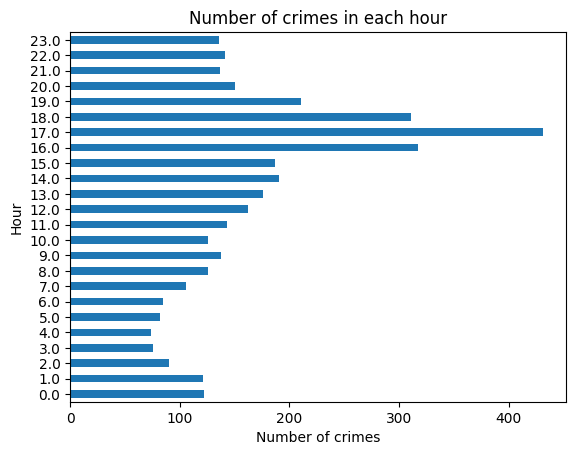

In [43]:
# Visualization 1
# Yuxin Shen
cta_data = pd.read_csv("CleanedData.csv")
cta_data.index = pd.DatetimeIndex(cta_data.Time)
cta_data['hour'] = cta_data.index.hour
cta_data.groupby([cta_data.hour]).size().plot(kind='barh')
plt.ylabel('Hour')
plt.xlabel('Number of crimes')
plt.title('Number of crimes in each hour')
plt.show()

Yuxin: The data shows a clear peak in crime rates during the evening and nighttime hours, especially between 17:00 and 23:00, or 5-11 pm. Some possible reason for this peak are reduced visibility and fewer people on the streets.

There is a significant increase in crime is observed around 16:00 or 4 pm. Many school day end around this time, leading to more people on the streets. This afternoon peak could be related to the transition between school and work hours.

In the early morning 3:00 to 6:00, the data shows a decrease in crime rates.

This may be due reduced ridership. It's also possible that those who commit crimes have gone home and are in bed!

To address the increased crime rates during nighttime hours, transit officials can improve street lighting, especially in areas with high crime rates. They should also install and maintain surveillance cameras to deter criminal activities and assist in investigations.

The presence of transit police and security personnel can be increased during peak crime hours. Transit security can collaborate with local law enforcement to address hotspots and coordinate efforts to improve overall safety.


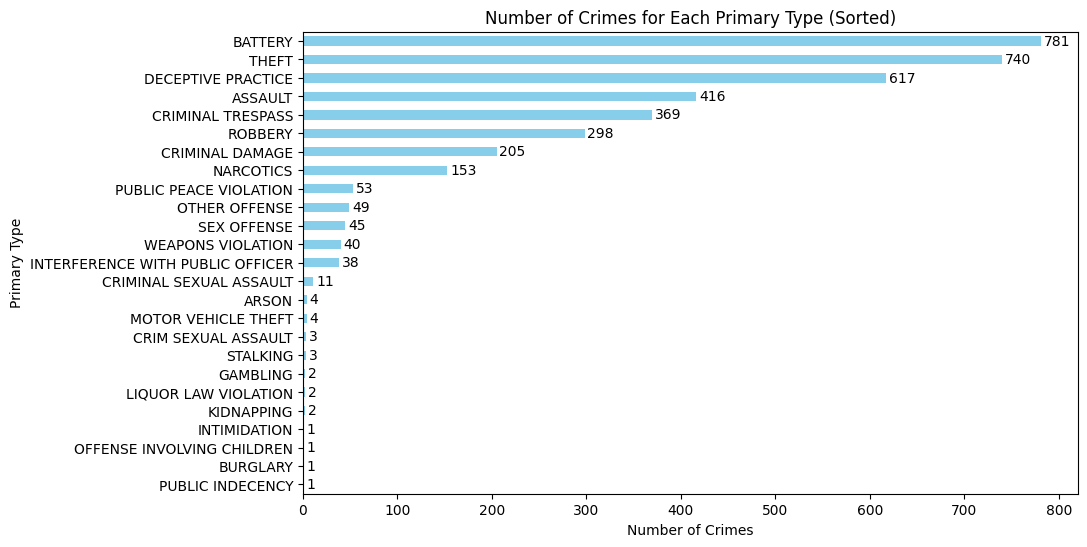

In [34]:
# Visualization 2
# Yuxin Shen

cta_data = pd.read_csv("CleanedData.csv")


crime_counts = cta_data.groupby(['Primary Type']).size().sort_values()

plt.figure(figsize=(10, 6))
ax = crime_counts.plot(kind='barh', color='skyblue')

for i, v in enumerate(crime_counts):
    ax.text(v + 3, i, str(v), color='black', va='center')

plt.ylabel('Primary Type')
plt.xlabel('Number of Crimes')
plt.title('Number of Crimes for Each Primary Type (Sorted)')
plt.show()



Yuxin: The graph indicates the total number of crimes for each type. In order the top 6 crimes are: battery, theft, deceptive practice, assault, and criminal trepass. By knowing the most common types of crime, transit security and authorities can tailor their strategies to proactively address specific vulnerabilities, allocate resources more effectively, and implement targeted preventive measures.

In [40]:
# Visualization 3
# Lukas Renfree
import folium
from folium.plugins import HeatMap

df = pd.read_csv("CleanedData.csv")
map_chicago = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Ensure that latitude and longitude columns are numeric
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Drop any rows with missing latitude or longitude values
df = df.dropna(subset=['Latitude', 'Longitude'])

# Create a HeatMap layer using latitude and longitude data
heat_data = [[row['Latitude'], row['Longitude']] for index, row in df.iterrows()]

HeatMap(heat_data, alpha=0.3).add_to(map_chicago)

map_chicago


 Lukas: The heatmap shows the spatial distribution of crimes for the CTA. This was made follow the hypothesis that CTA stops in certain neighborhoods may have a higher density of crimes, which can be viewed here. The loop where all transit lines meet and where there are higher population display an elevated intensity of reported crimes. The several of the ends of transit lines also are quite red, indicating a high amounts of crime.

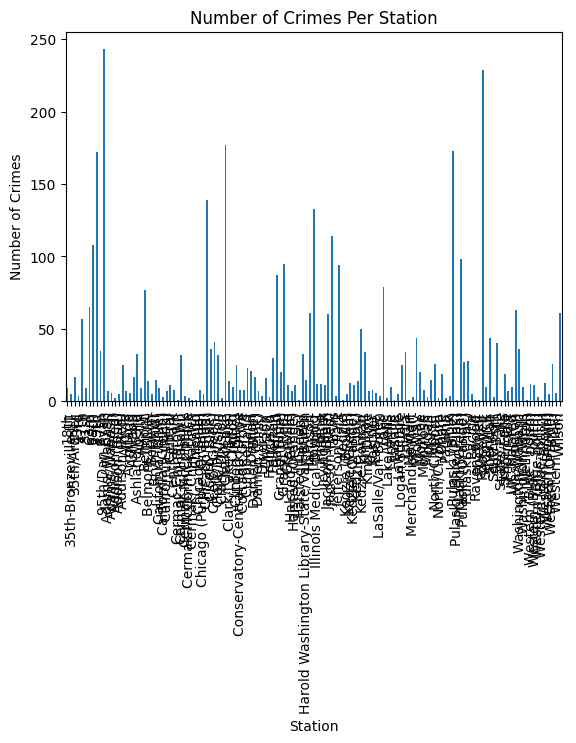

In [ ]:
# Visualization 4.1
# Lili Velazquez

cta_data = pd.read_csv("CleanedData.csv")

# to work with a smaller database with only 2 colums: the stations and the type of crime
sc = cta_data[['Primary Type', 'Station']]

# group the stations together to plot them as a bar graph
gr = sc.groupby("Station").size().plot(kind='bar')

# the title of the bar graph
plt.title('Number of Crimes Per Station')

# label the axes
plt.xlabel('Station')
plt.ylabel('Number of Crimes')

# show the bar graph
plt.show()

Lili Velazquez:

This visualization shows that there are six stations where crime occurs the most. These stations have over 125 crimes over the past 5 years.

Because this graph is a bit hard to decipher with the many station names, we made a version that feature only the top 20 stations with the highest number of crimes, which can be seen below.

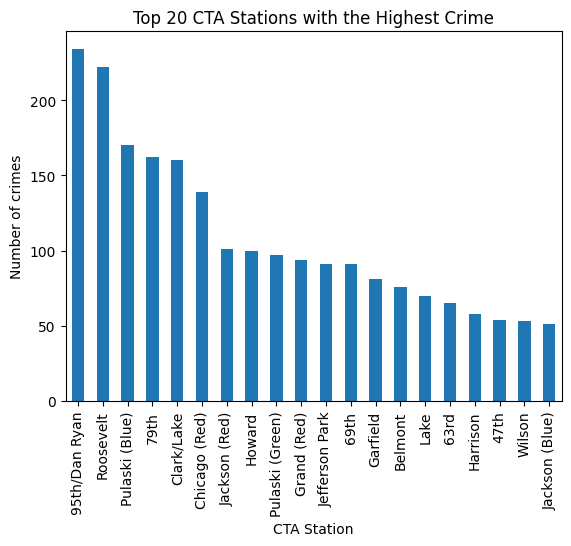

In [ ]:
# Visualization 4.2
#Susan Chen
# read in data
cta_data = pd.read_csv("CleanedData.csv")

# group by station name and count the total number of crimes for each station
station_crime_counts = cta_data['Station'].value_counts()

# top 20 stations with the highest crime
top_20_stations = station_crime_counts.head(20)

# plot the bar graph
top_20_stations.plot(kind='bar')
plt.xlabel('CTA Station')
plt.ylabel('Number of crimes')
plt.title('Top 20 CTA Stations with the Highest Crime')
plt.show()

Susan: The bar graph above shows the top 20 CTA stations of the highest crime. One of the hypotheses suggest that some CTA stations in certain neighborhoods might have higher crime rates due to a number of factors. This graph allows us to analyze which stations have the highest crime rates, which is useful when determining which stations should have increased security.

Below are notes of the location for each stop. They were made by looking at a map of the CTA. We concluded that the ends of transit lines, intersections of transit lines, and stations in or next to the loop had higher rates of crime. This conclusion is supported by the heat map as well.

95th/Dan Ryan - end of red line \
Roosevelt - where red, orange, and green meet \
Pulaski (Blue) - towards end of blue, next to West Garfield park \
79th - towards end of red line\
Clark/ Lake - middle of city \
Chicago (Red)- middle of city, just out of loop \
Jackson (Red) - middle of city, where two major lines (blue and red) are connected \
Howard - end of red line \
Pulaski (Green) - West Garfield Park \
Grand (Red) - just outside loop \
Jefferson Park - towards end of blue \
69th - towards end of red \
Belmont - intersection of three transit lines \
Lake - middle of city, loop \
63rd - towards end of red \
Harrison - loop \
47th - South of loop \
Wilson - Up north red line \
Jackson (Blue) -  middle of city, where two major lines (blue and red) are connected \




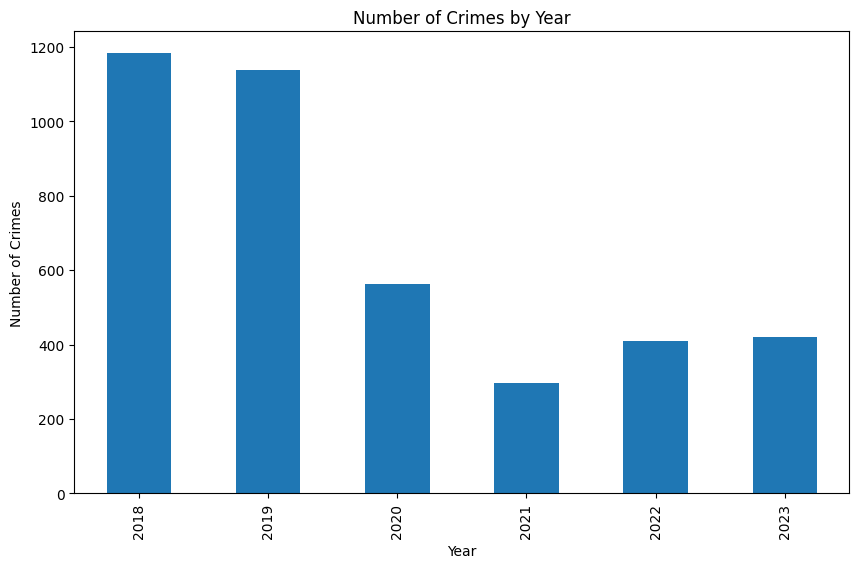

In [ ]:
#Visualizaiton 5
#Susan Chen
cta_data = pd.read_csv("CleanedData.csv")
cta_data['Date'] = pd.to_datetime(cta_data['Date'])

# extracting'year' from  timestamp
cta_data['Year'] = cta_data['Date'].dt.year

# plot the bar graph
cta_data.groupby('Year').size().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes by Year')
plt.show()

Susan: The bar graph above shows the number of crimes by year, indicating that the total number of crimes have dropped significantly since 2019. The initial drop could be attributed to the COVID-19 pandemic, especially in 2020, but it is unusual to see that drop persist in 2022 and 2023. Transit authorities should evaluate what practices have changed and possibly intensify them to keep these lower crime counts.




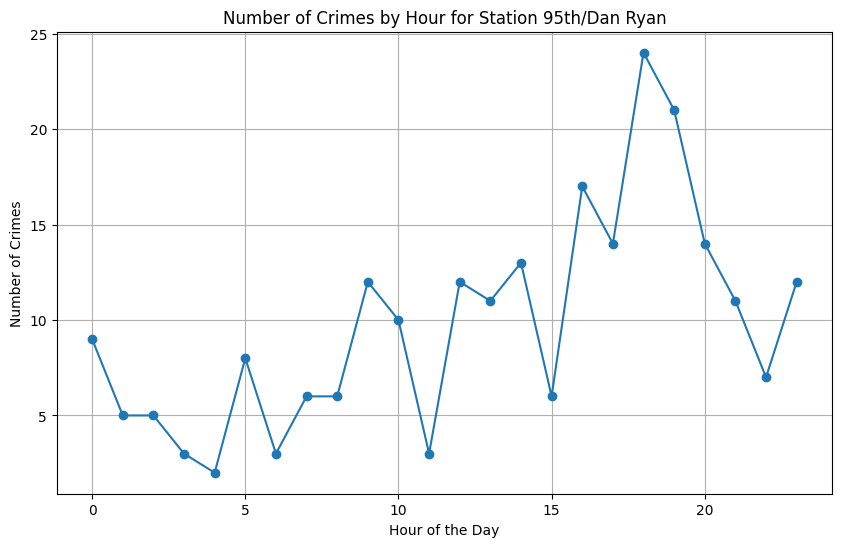

In [ ]:
#Visualization 6
#Susan Chen
cta_data = pd.read_csv("CleanedData.csv")
cta_data['Time'] = pd.to_datetime(cta_data['Time'])

# Filtering data for the station '95th/Dan Ryan'
cta_data_95th = cta_data[cta_data['Station'] == '95th/Dan Ryan'].copy()

# Extracting the 'hour' from the timestamp
cta_data_95th['Hour'] = cta_data_95th['Time'].dt.hour

# Plotting the line plot
cta_data_95th.groupby('Hour').size().plot(kind='line', marker='o', figsize=(10, 6))

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes by Hour for Station 95th/Dan Ryan')
plt.grid(True)
plt.show()

Susan: The line plot above shows the number of crimes by hour for the station ‘95th/Dan Ryan’. From previous analyses, the station with the highest number of crimes within our dataset is 95th/Dan Ryan. Therefore, we wanted a more detailed visualization of the relationship between the time of the day and how many crimes occur within that hour.

Since our hypotheses predict that crimes increase after 10pm and return to normal around 5am, we wanted to see if our data can confirm or deny those hypotheses for the station with the highest number of crimes. We also wanted to see how this grpah compares to the overall crimes by hour and similarly there is a spike in crime counts from 4-11 pm. The lowest number of crimes is also around 3-4 am.

This visualization can be done with other stations to determine the hours a specific stop has the highest number of reported crimes.


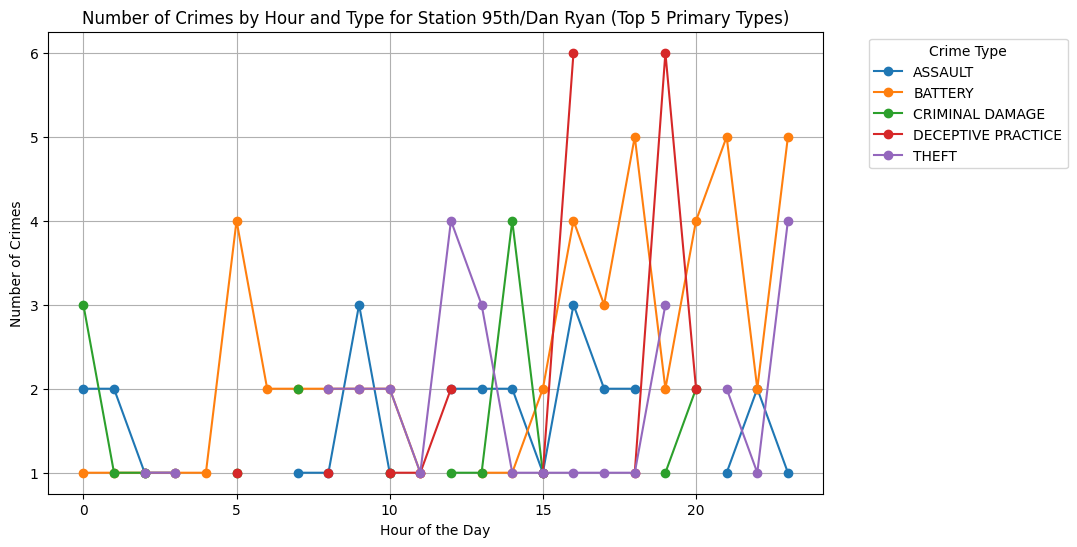

In [44]:
# Visualization 7
# Lukas

cta_data = pd.read_csv("CleanedData.csv")
cta_data['Time'] = pd.to_datetime(cta_data['Time'])

cta_data_95th = cta_data[cta_data['Station'] == '95th/Dan Ryan'].copy()

# Extracting the 'hour' from the timestamp
cta_data_95th['Hour'] = cta_data_95th['Time'].dt.hour

# Getting the top 5 primary types by count
top_primary_types = cta_data_95th['Primary Type'].value_counts().nlargest(5).index

# Filtering data for the top 5 primary types
cta_data_top_types = cta_data_95th[cta_data_95th['Primary Type'].isin(top_primary_types)]

# Plotting the line plot for each crime type
crime_by_hour = cta_data_top_types.groupby(['Hour', 'Primary Type']).size().unstack().plot(kind='line', marker='o', figsize=(10, 6))

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes by Hour and Type for Station 95th/Dan Ryan (Top 5 Primary Types)')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



Lukas: This graph shows the top 5 different types of crimes at the 95th/Dan Ryan Station, which is the station with the most crimes.  It shows the different types along with the hour of the day.

From previous graphs we determined that 4-11 pm is when most crimes occur. Battery and deceptive practice follow this pattern, but theft and criminal damage peak more around noon-3 pm.

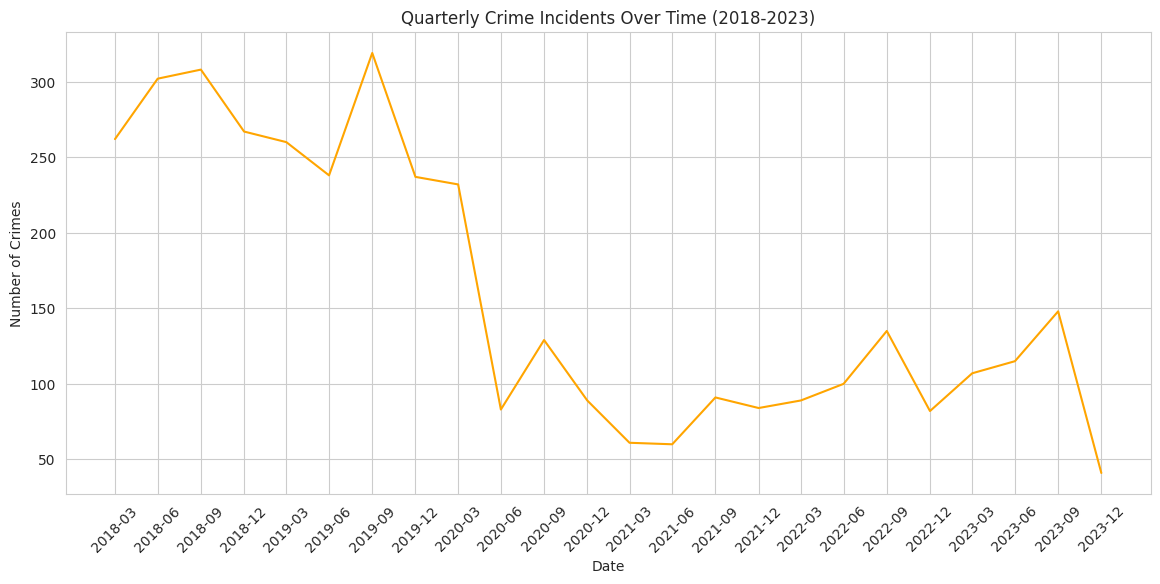

In [5]:
#Visualization 8

file_path = 'CleanedData.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])

# Set the 'date' column as the index for time series analysis
df.set_index('Date', inplace=True)

# Resample the data to aggregate it by quarter
quarterly_crime = df.resample('Q').size()

# Plotting
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
sns.lineplot(x=quarterly_crime.index, y=quarterly_crime.values, color='orange')
plt.title('Quarterly Crime Incidents Over Time (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')

# Customize x-axis ticks for quarters
plt.xticks(quarterly_crime.index, quarterly_crime.index.strftime('%Y-%m'), rotation=45)

plt.show()


Generally, there is a pattern of higher crime rates in the third quarter of each year, followed by a decrease in the fourth quarter. This can be seen by looking at the jump between the sixth-ninth months of any year and the fall between the ninth-twelfth months. The first and second quarters show varying levels of crime, with the second often being lower.

In several years, the first quarter tends to have the fewest reported crimes. The fourth quarter consistently has lower crime rates compared to the third in each year.

The third quarter or the summer quarter of the year may have increased crime activity because warmer temperatures and longer days in the summer often lead to increased outdoor activities. This may result in more people being out in public spaces, creating opportunities for various types of crimes. Also many people take vacations during the summer months, leading to an influx of tourists that may be targeted for crimes like theft, robbery, and scams.

Decreased activity in the fourth quarter or the fall-winter part of the year could be due to people spending less time outdoors, which can result in fewer opportunities for certain types of crimes. Individuals may also be occupied with family activities during the holidays, reducing the likelihood of engaging in criminal behavior.

The first quarter, January-March, may have the fewest reported crimes because of colder conditions similar to the fourth quarter. It may also be due to reduced tourism after the holidays.

As for changes in between years, there is a noticeable decrease in crime incidents from 2018 to 2019. A significant drop is observed in crime rates from 2019 to 2020, particularly in the second quarter, which might be influenced by external factors such as the COVID-19 pandemic.

There's a subsequent increase in crimes in the third quarter of 2020 and first quarter of 2021, possibly reflecting changes in social and economic conditions during the pandemic. From 2021 to 2022, there is a general upward trend in crime rates, evident in the third quarter.

Although these trends may mostly be due to the COVID-19 pandemic, transit authorities can also examine the policies and practices that were put into effect to determine if they are also helping to decrease crime rates.

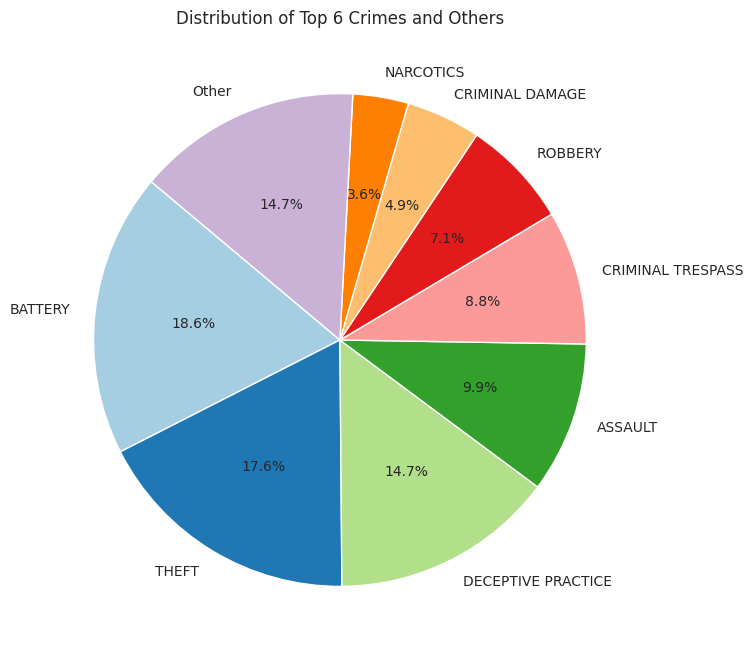

In [ ]:
#Visualization 9

#Tiffany Love Stephens
#Pie chart of the most common crimes

df = pd.read_csv('CleanedData.csv')


# Calculate the count of each crime type
crime_counts = df['Primary Type'].value_counts()


# Select the top 6 crimes and sum the counts of the rest
top_crimes = crime_counts.head(8)
other_crimes_count = crime_counts[6:].sum()


# Create a new Series with top crimes and 'Other'
modified_crime_counts = pd.concat([top_crimes, pd.Series({'Other': other_crimes_count})])


# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(modified_crime_counts, labels=modified_crime_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Top 6 Crimes and Others')
plt.show()


The pie chart indicates that battery is the most common type of crime comprising 18.6% of all crimes. Battery involves physical harm to another person. To protect riders from this, stations should be well-lit at the platform itself and outside the station. Currently there are many stops that have limited lighting just outside the doors of buildings where riders enter and exit the stop. Stops that have high crime volumes can also have increased security.

Theft makes up 17.6% of all crimes and robbery is at 7.1%. These two are discussed together because a robbery is theft with the use of force, threat, or intimidation. Both theft and robbery can be prevented with increased security and providing other workers that can handle reports of suspicious behavior. Riders can protect themselves by being aware of their surroundings, especially in crowded areas, and using anti-theft backpacks.

Deceptive Practice is the next largest category at 14.7% and it may include scams or fraudulent activities. Passengers should be cautious of suspicious behavior, such as strangers asking for personal information or offering unsolicited services. Transit authorities can educate or bring awareness to common scams by putting up posters or having short announcements for riders waiting at the platform.

Assault is 9.9% and like several other crimes can be address by increased security. At platforms and on trains there can be increased emergency buttons that would be pressed when there is an active assault happening.

In summary, transit authorities should increase security, provide more options to report active crimes and suspicious behavior, bring awareness to common fraudulent activities, and improve lighting so riders can see more of their surroundings. This may help bring the number of crimes down and protect the thousands of riders of the CTA.

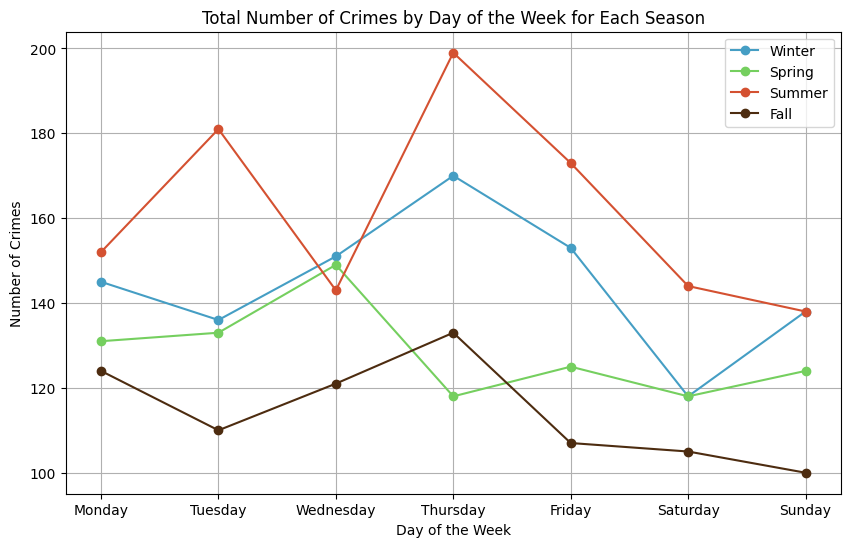

Winter
Monday - 145 crimes
Tuesday - 136 crimes
Wednesday - 151 crimes
Thursday - 170 crimes
Friday - 153 crimes
Saturday - 118 crimes
Sunday - 138 crimes

Spring
Monday - 131 crimes
Tuesday - 133 crimes
Wednesday - 149 crimes
Thursday - 118 crimes
Friday - 125 crimes
Saturday - 118 crimes
Sunday - 124 crimes

Summer
Monday - 152 crimes
Tuesday - 181 crimes
Wednesday - 143 crimes
Thursday - 199 crimes
Friday - 173 crimes
Saturday - 144 crimes
Sunday - 138 crimes

Fall
Monday - 124 crimes
Tuesday - 110 crimes
Wednesday - 121 crimes
Thursday - 133 crimes
Friday - 107 crimes
Saturday - 105 crimes
Sunday - 100 crimes



In [25]:
# Visualization 10
# Tiffany Love Stephens
df = pd.read_csv('CleanedData.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Extract the day of the week
df['Day_of_Week'] = df['Date'].dt.day_name()

# Define the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reorder the levels of the 'Day_of_Week' column
df['Day_of_Week'] = pd.Categorical(df['Day_of_Week'], categories=day_order, ordered=True)

# Extract the quarter of the year and label with seasons
df['Season'] = pd.cut(df['Date'].dt.month, [0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])
df['Quarter'] = df['Date'].dt.quarter

# Count the number of crimes for each day and quarter
crime_counts = df.groupby(['Season', 'Day_of_Week']).size().unstack()

# Create a line graph for each quarter with assigned colors
plt.figure(figsize=(10, 6))
colors = {'Winter': '#459ec4', 'Spring': '#75cf5f', 'Summer': '#d45131', 'Fall': '#4d2c10'}
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    plt.plot(crime_counts.columns, crime_counts.loc[season], marker='o', linestyle='-', label=season, color=colors[season])

# Customize the plot
plt.title('Total Number of Crimes by Day of the Week for Each Season')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.legend()
plt.grid(True)
plt.show()

# Print the number of crimes for each day of the week for each season
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    print(season)
    for day in day_order:
        crime_count = crime_counts.loc[season, day]
        print(f"{day} - {crime_count} crimes")
    print()


In the winter, Thursdays have the highest number of crimes (170), followed by Wednesdays (151). Saturdays have the lowest number of crimes (118).

In the spring, Wednesdays have the highest number of crimes (149), followed by Mondays (131). Thursdays have the lowest number of crimes (118).

Summer has Thursdays with the highest number of crimes (199), followed by Tuesdays (181). Sundays have the lowest number of crimes (138).

Lastly, Fall also has Thursdays as the day with the highest number of crimes (133), followed by Wednesdays (121). Sundays and Saturdays have the lowest number of crimes (100 and 105, respectively).

Overall Thursdays appear to be a day with higher crime rates in all seasons except for Spring. Weekends, especially Saturdays and Sundays, generally have lower crime rates across all seasons. This was surprising to us because we assumed that weekends would have high crime counts due to increased volumes of riders. Higher rates of crime on weekdays may be due to less security compared to the weekends. It could also be because at later hours during the weekday, there are more situations when riders are alone at the station. On weekends, there are more people on the platform able to witness crimes

## **3.Machine Learning Analyses**
At least two ML analyses on your dataset, along with a baseline comparison and an interpretation of the result that you obtain.
Write the name of the member(s) who is responsible for it while explaining it.


In [ ]:
data = pd.read_csv('CleanedData.csv')

In [ ]:
np.count_nonzero(data.isnull())

569

In [ ]:
data.dropna(how='any', axis=0, inplace=True)

In [ ]:
#Yuxin Shen
data.index = pd.DatetimeIndex(data.Date)
data['hour'] = data.index.hour
data['Month'] = data.index.month
data['dayType'] = data['hour'].apply(lambda x: 'afternoon and evening' if (x >= 13 and x < 21) else 'Others')
data['dayOfMonth'] = data.index.day
data['dayOfYear'] = data.index.dayofyear

data = data.sort_index()
print(data)
data.shape

                           ID Case Number              Date  \
Date                                                          
2018-01-03 15:10:00  11194471    JB103237    1/3/2018 15:10   
2018-01-04 09:00:00  11195256    JB104394     1/4/2018 9:00   
2018-01-04 23:00:00  11195670    JB104830    1/4/2018 23:00   
2018-01-05 22:00:00  11196600    JB106143    1/5/2018 22:00   
2018-01-07 12:15:00  11197638    JB107556    1/7/2018 12:15   
...                       ...         ...               ...   
2023-10-30 11:13:00  13260685    JG484429  10/30/2023 11:13   
2023-10-30 23:03:00  13261409    JG485226  10/30/2023 23:03   
2023-10-31 11:58:00  13261935    JG485828  10/31/2023 11:58   
2023-10-31 20:40:00  13262456    JG486466  10/31/2023 20:40   
2023-10-31 22:48:00  13262470    JG486544  10/31/2023 22:48   

                                      Block       Primary Type  \
Date                                                             
2018-01-03 15:10:00   002XX W GARFIELD BLVD  CRI

(3452, 24)

In [ ]:
#Yuxin Shen
#split function
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
#Yuxin Shen
data_tr = data.loc['2018-01-01':'2022-12-31']
print(data_tr)
data_test = data.loc['2023-01-01':'2023-12-31']
#listOfComms = list(data['Community Area'].unique())


train_d_day = []
train_d_night = []
#df = data_tr[data_tr['Community Area'] == comm]
df = data_tr
df_gr = df.groupby(['Year', 'dayOfYear', 'dayType']).count()
#print(df)
idx = pd.IndexSlice
df_gr_1 = df_gr.loc[idx[:, :, 'afternoon and evening'], :]
train_d_night.append(list(df_gr_1['Date'].values))

idx = pd.IndexSlice
df_gr_2 = df_gr.loc[idx[:, :, 'Others'], :]
train_d_day.append(list(df_gr_2['Date'].values))


test_d_day = []
test_d_night = []
df = data_test
df_gr = df.groupby(['Year', 'dayOfYear', 'dayType']).count()
    #print(df)
idx = pd.IndexSlice
df_gr_1 = df_gr.loc[idx[:, :, 'afternoon and evening'], :]
test_d_night.append(list(df_gr_1['Date'].values))

idx = pd.IndexSlice
df_gr_2 = df_gr.loc[idx[:, :, 'Others'], :]
test_d_day.append(list(df_gr_2['Date'].values))






                           ID Case Number              Date  \
Date                                                          
2018-01-03 15:10:00  11194471    JB103237    1/3/2018 15:10   
2018-01-04 09:00:00  11195256    JB104394     1/4/2018 9:00   
2018-01-04 23:00:00  11195670    JB104830    1/4/2018 23:00   
2018-01-05 22:00:00  11196600    JB106143    1/5/2018 22:00   
2018-01-07 12:15:00  11197638    JB107556    1/7/2018 12:15   
...                       ...         ...               ...   
2022-12-21 19:29:00  12929902    JF519185  12/21/2022 19:29   
2022-12-22 14:00:00  12930639    JF520033  12/22/2022 14:00   
2022-12-28 18:05:00  12935203    JF525614  12/28/2022 18:05   
2022-12-29 00:59:00  12935470    JF525848   12/29/2022 0:59   
2022-12-29 16:00:00  12936062    JF526583  12/29/2022 16:00   

                                             Block        Primary Type  \
Date                                                                     
2018-01-03 15:10:00          002

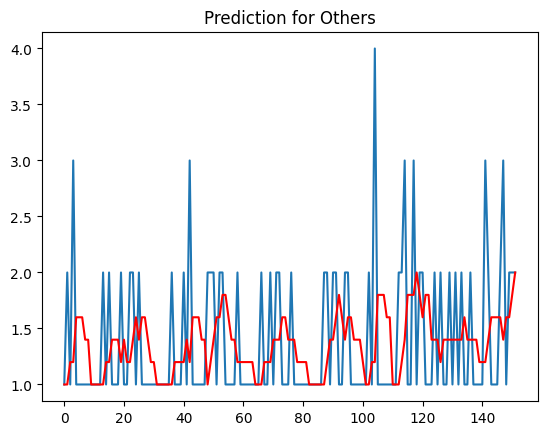

Error for : 0.6525254582652009
Test RMSE: 0.653


In [ ]:
#Yuxin Shen
# prepare situation
window = 5
predTot = list()
testTot = list()
# walk forward over time steps in test
for distNum in range(len(train_d_day)):

    history = train_d_day[distNum]
    test = test_d_day[distNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length - window, length)])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)

    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.title('Prediction for Others')
    plt.show()

    error = mean_squared_error(preds, test) ** .5
    print('Error for : {}'.format(error))

    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

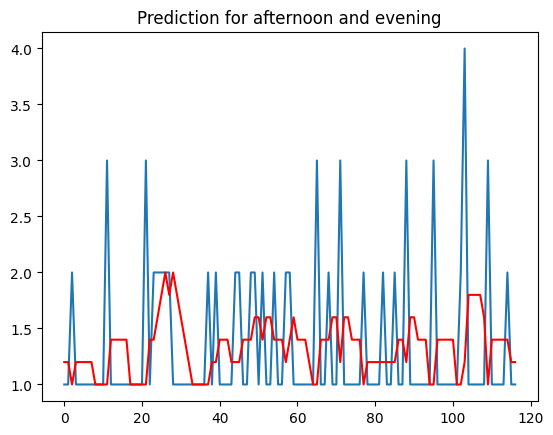

Test RMSE: 0.717


In [ ]:
#Yuxin Shen
# prepare situation
window = 5
predTot = list()
testTot = list()
# walk forward over time steps in test
for distNum in range(len(train_d_night)):

    history = train_d_night[distNum]
    test = test_d_night[distNum]
    preds = []
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length - window, length)])
        obs = test[t]
        preds.append(yhat)
        history.append(obs)

    # plot
    plt.plot(test)
    plt.plot(preds, color='red')
    plt.title('Prediction for afternoon and evening')
    plt.show()

    testTot = testTot + test
    predTot = predTot + preds
error = mean_squared_error(predTot, testTot) ** .5
print('Test RMSE: %.3f' % error)

A3:We trained with data from 2018-2022, divided into 13-21 (afternoon and evening) as well as other times, to make predictions for the results in 2023, and the predictions are shown in the figure, where our results have a smaller rmse, and therefore more accurate results.

Susan Chen: We wanted to test our hypothesis that crime rates will be higher for all train stations after 10pm and would return to normal around 5am. Below is a binary classification analysis on predicting whether a crime did occur between 10pm and 5am. We trained our logistic regression model to predict the probability of an instance belonging to class 1 (crime occurred between 10:00 PM and 5:00 AM) or 0 (no crime occurred between 10:00 PM and 5:00 AM) based on a list of features.

Baseline Accuracy: 0.812975164723771
Model Accuracy: 0.8468354430379746
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       631
           1       0.84      0.30      0.44       159

    accuracy                           0.85       790
   macro avg       0.84      0.64      0.67       790
weighted avg       0.85      0.85      0.82       790

Improvement Over Baseline: 0.033860278314203685


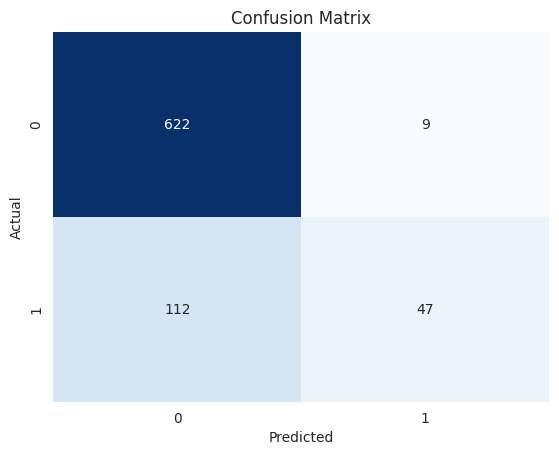

In [ ]:
#Susan Chen

# read in data
data = pd.read_csv('CleanedData.csv')

# prepare for comparison
data['Time'] = pd.to_datetime(data['Time'])
data['Time_Hour'] = data['Time'].dt.hour
data['Time_Minute'] = data['Time'].dt.minute
data['Time_Hour_Minute'] = data['Time'].dt.strftime('%H:%M')

# create binary target variable indicating whether a crime occurred after 10:00 PM or not
data['crime_after_10pm_and_before_5am'] = ((data['Time_Hour_Minute'] > '22:00') | (data['Time_Hour_Minute'] < '05:00')).astype(int)
#print(data[['Time_Hour_Minute', 'crime_after_10pm_and_before_5am']].head(30))

features = ['Time_Hour', 'Time_Minute', 'Station', 'District', 'Ward', 'Community Area']
X = data[features] #independent variables
y = data['crime_after_10pm_and_before_5am']  # dependent/target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


baseline_accuracy = y.value_counts(normalize=True).max()
print(f'Baseline Accuracy: {baseline_accuracy}')

# define preprocessing for numeric and categorical features
numeric_features = ['Time_Hour', 'Time_Minute']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['Station', 'District', 'Ward', 'Community Area']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# append classifier to preprocessing pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42))])

# train the model
clf.fit(X_train, y_train)

# model evaluation
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Model Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

# compare model accuracy with baseline accuracy
improvement_over_baseline = accuracy - baseline_accuracy
print(f'Improvement Over Baseline: {improvement_over_baseline}')

conf_matrix = confusion_matrix(y_test, y_pred)
# visualize conf_matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Susan Chen: From the results, our model is overall quite accurate, with an accuracy of 84.7% in representing the proportion of correctly predicted instances (both class 0 and class 1) out of the total instances in the test set. However, the low recall value for class 1 suggests that our model faced challenges in correctly identifying instances where a crime occurred, which also contributed to the high number of false negatives shown in the Confusion Matrix. Precision is balanced for both classes. Our model also improved in accuracy by 3.39% over a simple baseline that always predicts the majority class.

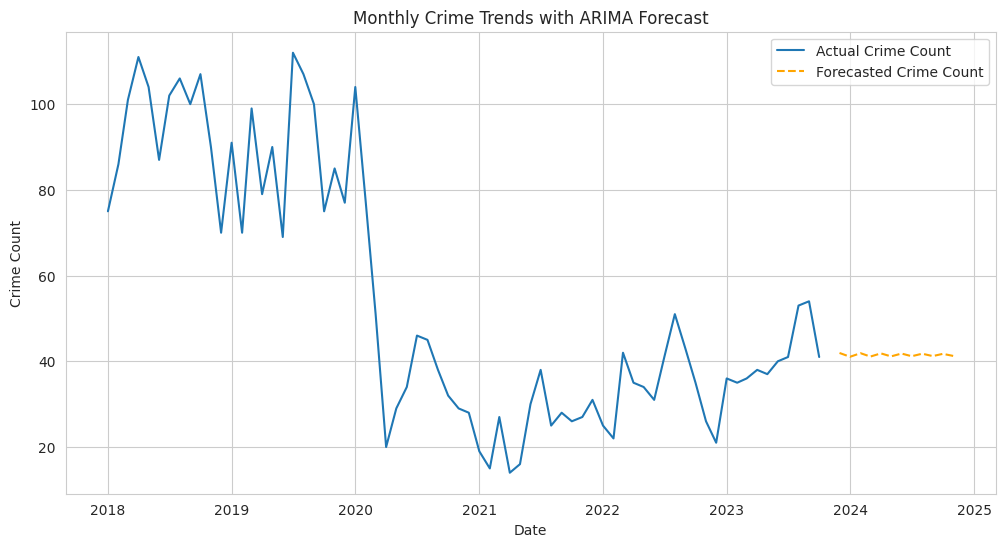

Forecasted Crime Count:
2023-11-30: 41.941644870892276
2023-12-31: 41.05350686834636
2024-01-31: 41.891178410929946
2024-02-29: 41.101105684345896
2024-03-31: 41.84628429142465
2024-04-30: 41.14344879569923
2024-05-31: 41.80634723287806
2024-06-30: 41.18111652002032
2024-07-31: 41.77081989292953
2024-08-31: 41.214625098161626
2024-09-30: 41.73921536496096
2024-10-31: 41.24443376935931


In [9]:
#Tiffany Love Stephens
# Temporal Analysis - Monthly Crime Trends to predict number of crimes in future months

# Load data from CSV
crime_data = pd.read_csv("CleanedData.csv")

# Assuming 'Date' column is in datetime format
crime_data['Date'] = pd.to_datetime(crime_data['Date'])

# Extracting year, month, and day for temporal analysis
crime_data['year'] = crime_data['Date'].dt.year
crime_data['month'] = crime_data['Date'].dt.month
crime_data['day'] = crime_data['Date'].dt.day

# Monthly crime count
monthly_crime = crime_data.groupby(['year', 'month']).size().reset_index(name='crime_count')

# Create a datetime index for the plot
monthly_crime['date'] = pd.to_datetime(monthly_crime[['year', 'month']].assign(day=1))

# Fit ARIMA model
model = ARIMA(monthly_crime['crime_count'], order=(1, 1, 1))
result = model.fit()

# Forecast future values
future_dates = pd.date_range(start=monthly_crime['date'].max(), periods=13, freq='M')[1:]  # Adjust the number of periods as needed
future_values = result.forecast(steps=12)

# Plotting the temporal analysis with forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_crime['date'], monthly_crime['crime_count'], label='Actual Crime Count')
plt.plot(future_dates, future_values, label='Forecasted Crime Count', linestyle='--', color='orange')
plt.title('Monthly Crime Trends with ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

# Print forecasted values
print("Forecasted Crime Count:")
for date, count in zip(future_dates, future_values):
    print(f"{date.strftime('%Y-%m-%d')}: {count}")

The forecasted values are relatively close to each other, indicating that the model expects a consistent number of crimes across the forecasted months. Judging by the rest of the graph, the expected number of crimes is not too accurate. It should fluctuate more throughout each quarter.

The stability in the forecast might be due to the inherent nature of the data or the simplicity of the ARIMA model. ARIMA models may sometimes produce conservative forecasts, especially if the historical data does not exhibit strong trends or seasonality.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


List of Stations with Anomalies:
['87th' '95th/Dan Ryan' 'Austin' 'Central' 'Cottage Grove' 'Cumberland'
 'Harlem' 'Howard' 'Midway' 'Ohare' 'Pulaski (Orange)']


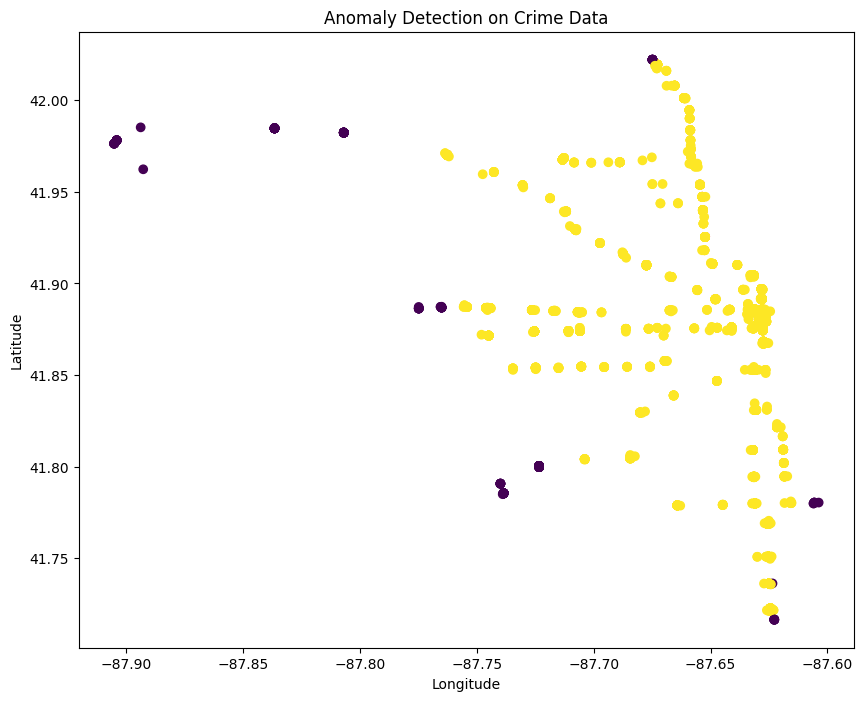

In [47]:
#Tiffany Love Stephens
#Anomaly Detection

# Load data from CSV
crime_data = pd.read_csv("CleanedData.csv")

# Assuming 'Date' column is in datetime format
crime_data['Date'] = pd.to_datetime(crime_data['Date'])

# Extracting relevant features for anomaly detection
features = crime_data[['Latitude', 'Longitude']]

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# Train the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05)  # Adjust the contamination parameter
isolation_forest.fit(features_imputed)

# Predict outliers (anomalies)
predictions = isolation_forest.predict(features_imputed)

# Add the predictions to the original DataFrame
crime_data['Anomaly'] = predictions

# Filter anomalies
anomalies = crime_data[crime_data['Anomaly'] == -1]

# List of unique station names with anomalies
unique_anomaly_stations = anomalies['Station'].unique()

# Print the list of station names with anomalies
print("List of Stations with Anomalies:")
print(unique_anomaly_stations)

# Plot anomalies on a map (assuming you have latitude and longitude information)
plt.figure(figsize=(10, 8))
plt.scatter(crime_data['Longitude'], crime_data['Latitude'], c=crime_data['Anomaly'], cmap='viridis')
plt.title('Anomaly Detection on Crime Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# In top 20 highest crime stop out of anomalies:
# 95th/Dan Ryan, Howard


The purple dots represent anomalies in the data and all dots are towards the end of transit lines. This means that they have higher rates of crime relative to their location to other stops. In the visualization portion of this report, there were several graphs where we concluded that the ends of transit lines have higher rates of crimes in general.

Mean Squared Error: 0.21036337729241378
Feature Importances:
District: 0.035126099291312086
Ward: 0.09517667496174623
Community Area: 0.06412177671381719
X Coordinate: 0.2388272605589212
Y Coordinate: 0.16290748258963675
Latitude: 0.15541722492320859
Longitude: 0.24842348096135802


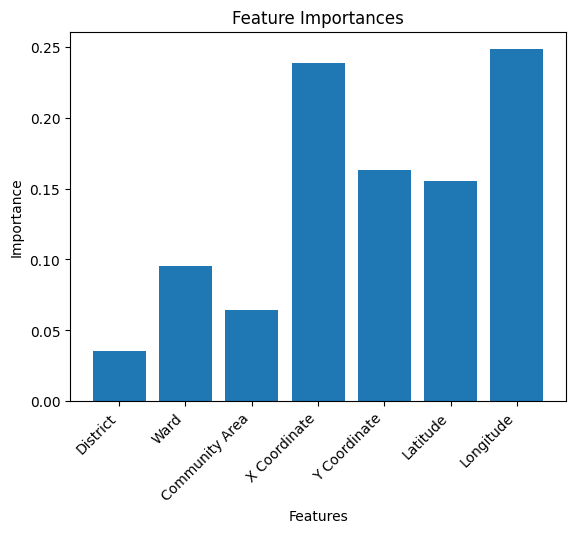

In [ ]:
data = pd.read_csv('CleanedData.csv')
# Lukas
# Selecting features and target variable
features = ['District', 'Ward', 'Community Area', 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude']
target = 'Arrest'

# Creating feature matrix (X) and target vector (y)
X = data[features]
y = data[target]

# Handling missing values
X = X.fillna(X.mean())

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Feature importances
feature_importances = rf_model.feature_importances_
print('Feature Importances:')
for feature, importance in zip(features, feature_importances):
    print(f'{feature}: {importance}')

# Visualizing feature importances
plt.bar(features, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.title('Feature Importances')
plt.show()


The purpose of this random forest model is to whether an arrest was made. The bar chart visually represents the importance of each feature. The higher the bar, the more important the corresponding feature is in predicting the target variable. The x-axis represents different features, and the y-axis represents their importance.


## **Additonal Work**



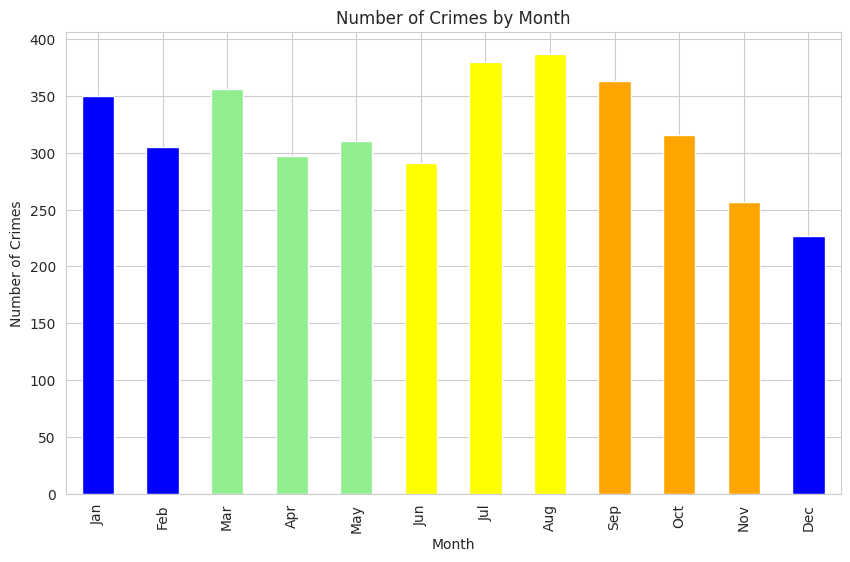

In [ ]:
#Susan Chen
cta_data = pd.read_csv("CleanedData.csv")
cta_data['Date'] = pd.to_datetime(cta_data['Date'])
cta_data['Month'] = cta_data['Date'].dt.month

# plot bar graph with custom colors for each season
cta_data.groupby('Month').size().plot(kind='bar', figsize=(10, 6), color=['blue', 'blue', 'lightgreen', 'lightgreen', 'lightgreen', 'yellow', 'yellow', 'yellow', 'orange', 'orange', 'orange', 'blue'])

plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes by Month')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


Susan: The bar graph above shows the number of crimes for each month, color coded by season. It shows that there is not a significant difference in the number of crimes by month, with the exception that December has lowest rate of crime.

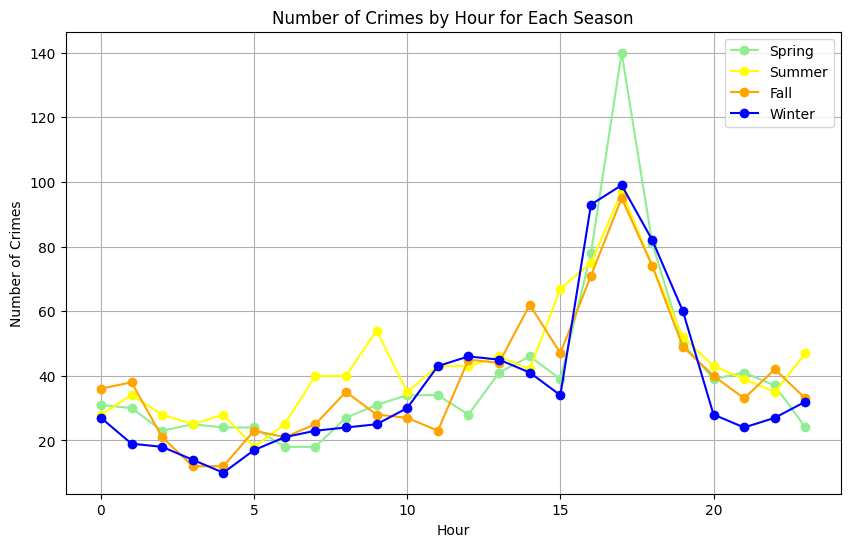

In [48]:
#Susan Chen

# Spring: March, April, May
# Summer: June, July, August
# Fall: September, October, November
# Winter: December, January, February

cta_data = pd.read_csv("CleanedData.csv")

# convert 'Date' and 'Time' columns to datetime
cta_data['DateTime'] = pd.to_datetime(cta_data['Date'] + ' ' + cta_data['Time'])

# extract 'hour' from the timestamp
cta_data['Hour'] = cta_data['DateTime'].dt.hour

# filter data for each season
spring_data = cta_data[(cta_data['DateTime'].dt.month >= 3) & (cta_data['DateTime'].dt.month <= 5)].copy()
summer_data = cta_data[(cta_data['DateTime'].dt.month >= 6) & (cta_data['DateTime'].dt.month <= 8)].copy()
fall_data = cta_data[(cta_data['DateTime'].dt.month >= 9) & (cta_data['DateTime'].dt.month <= 11)].copy()
winter_data = cta_data[(cta_data['DateTime'].dt.month == 12) | (cta_data['DateTime'].dt.month <= 2)].copy()

# plot line graph for each season
spring_data.groupby('Hour').size().plot(kind='line', marker='o', figsize=(10, 6), color='lightgreen', label='Spring')
summer_data.groupby('Hour').size().plot(kind='line', marker='o', color='yellow', label='Summer')
fall_data.groupby('Hour').size().plot(kind='line', marker='o', color='orange', label='Fall')
winter_data.groupby('Hour').size().plot(kind='line', marker='o', color='blue', label='Winter')

plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes by Hour for Each Season')
plt.legend()
plt.grid(True)
plt.show()


Susan: The above line graph shows the number of crimes by hour for the four seasons: Spring, Summer, Fall, and Winter. For each season, crime peaks around 17:00-18:00 (5-6pm) and drops around 19:00 (7pm). Spring has the highest peak compared to the other seasons. This could be due to the fact that the weather is getting warm from the winter cold.

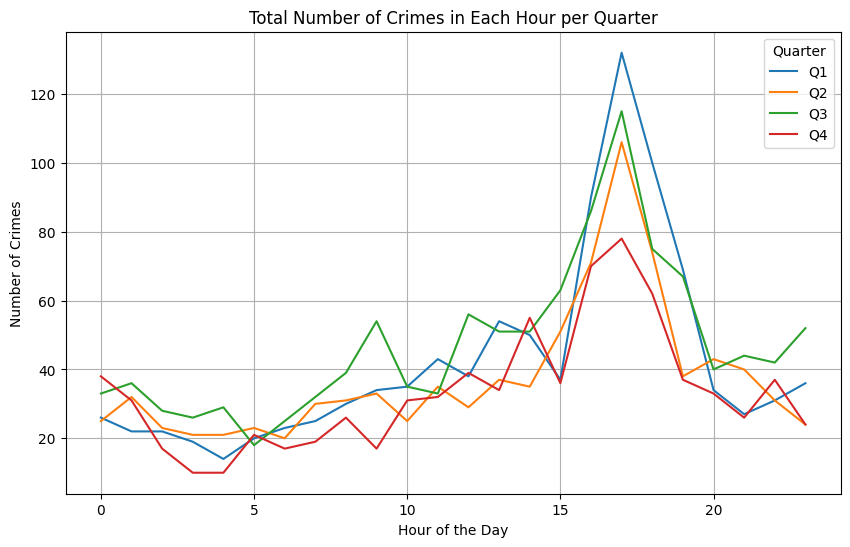

In [31]:
df = pd.read_csv('CleanedData.csv')
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Extract quarter and hour from the 'Datetime' column
df['Quarter'] = df['Datetime'].dt.quarter
df['Hour'] = df['Datetime'].dt.hour

# Group by quarter and hour, then count the number of crimes
crime_counts = df.groupby(['Quarter', 'Hour']).size().unstack().fillna(0)

# Plotting the line graph
fig, ax = plt.subplots(figsize=(10, 6))

for quarter in range(1, 5):
    ax.plot(crime_counts.loc[quarter], label=f'Q{quarter}')

ax.set_title('Total Number of Crimes in Each Hour per Quarter')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Quarter')
plt.grid(True)
plt.show()

## **Results**



Our next steps are still what we proposed in the initial phase of this project:  an interactive graph where you can click/hover over different areas and see information on that location.

We will completely clean data for all those missed points discussed in the clean data section.

Some graphs like the crime rate by station can be improved for readability.

We may want to produce more visualizations to explore the data more in-depth.

Draw conclusions based on data and determine if our hypothesis were supported or not.

